# Iterative Hessian Sketching for Regression
Code to reproduce results from https://arxiv.org/abs/1411.0347

In [444]:
import numpy as np
import scipy as sp
from sklearn.datasets import make_regression
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.linalg import norm

In [178]:
def gaussian_sketch(nrows, ncols):
    '''Generate a Gausian sketching matrix of size
    (nrows, ncols)'''
    return (1/np.sqrt(nrows))*np.random.randn(nrows, ncols)

In [461]:
def generate_data(nsamples, nfeatures, variance=1):
    '''Generates a data matrix of size (nsamples, nfeatures)
    which defines a linear relationship on the variables.'''
    X, y, coef = make_regression(n_samples=nsamples, n_features=nfeatures,\
                        n_informative=nfeatures,noise=variance,coef=True)
    #X[:,0] = np.ones(shape=(nsamples)) # add bias terms
    return X, y, coef

In [463]:
X,y, coef = generate_data(1000,2)
print(coef)
print(X.shape)

[ 68.83191399  96.10037031]
(1000, 2)


In [499]:
def iterative_hessian(data, targets, sketch_size, num_iters):
    '''
    Input:
    data - n x d matrix
    targets - n x 1 target variables
    num_iters - how many iterations to perform.  
    Need log(1/eps) -- > num_iters for eps accuracy where
    eps is relative error in the semi-norm ||u-v||_A = 
    1/sqrt(n)*||A(u-v)||_2.
    
    
    Add functionality for lower bound on sketch size
    '''
    A = data
    y = targets
    n,d = A.shape
    x0 = np.zeros(shape=(d,1))
    m = int(sketch_size) # sketching dimension
    
    ATy = A.T.dot(y)[:,None]
    covariance_mat = A.T.dot(A)
   
    for n_iter in range(int(num_iters)):
        S = gaussian_sketch(m, n)
        S_A = S.dot(A)
        B = S_A.T.dot(S_A)
        z = ATy - covariance_mat.dot(x0) + np.dot(S_A.T, (np.dot(S_A,x0)))
        sol = sp.linalg.lstsq(B,z)
        x_new = sol[0] 
        
        
        ### KEEP BELOW AS THIS WILL BE USED FOR LASSO OR
        ### PENALISED REGRESSION.
        
        #x0 = np.zeros((X.shape[0],1))
        #xt = np.zeros((2,1))
        #x_new = np.zeros((2,1))
        #for it in range(20):
        #    result = minimize(f2min, x0=x_new,args=(X,y,x_new),
        #                     method='L-BFGS-B', jac=False )
        #    print(result)
        #    x_new = result.x
        
        x_new = sp.linalg.solve(B,z)
        #print("ITERATION {}: ||x_t - x_t+1|| = {}".\
                  #format(n_iter, np.linalg.norm(x0-x_new)))
        x0 = x_new
    return np.ravel(x0)

In [466]:
x_hat = iterative_hessian(X,y, X.shape[0]//2, 10)

In [467]:
x_hat

array([[ 68.82638127],
       [ 96.08650998]])

In [475]:
x_true = sp.linalg.lstsq(X,y)
x_true[0]
print(x_true[0][:,None].shape)


(2, 1)


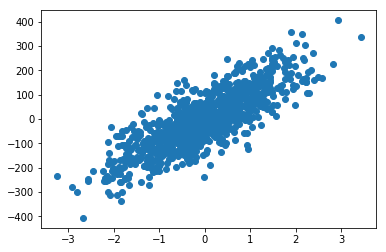

In [483]:
fig, ax = plt.subplots()
ax.scatter(X[:,1], y)
#ax.plot(X[:,1], np.sort(X@coef))
#ax.plot(X[:,1],X@x_hat)

### Checking the optimisation step
We need to use $x_{t+1} \leftarrow \text{argmin}_{x \in C} \|SA(x-x_t)\|_2^2 - (y - Ax_t)^TAx$.  To do this we will invoke the scipy minimizer but we this only minimises with one dimensional inputs so we need a local function.  

In [354]:
def lstsq(start_x, sketch, data, target):
    S = sketch #
    A = data
    y = target
    x0 = start_x
    return norm(S@A@x0-S@y)**2

In [361]:
res = minimize(lstsq, x0=np.zeros((2,1)),args=(gaussian_sketch(750,1000), X,y))

In [362]:
res

      fun: 4891280.004093261
 hess_inv: array([[ 0.00092058, -0.0009488 ],
       [-0.0009488 ,  0.00102779]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 68
      nit: 9
     njev: 17
   status: 0
  success: True
        x: array([  1.53622863,  19.1349492 ])

In [369]:
def f2min(x, data, target, offset):
    A = data
    S = np.eye(A.shape[0])
    #S = gaussian_sketch(nrows=A.shape[0]//2, ncols=A.shape[0] )
    #print(S.shape)
    #print(A.shape)
    y = target
    xt = np.ravel(offset)

    #print(xt.shape)
    #print((S@y).shape)
    #print((S@A@(x-xt)).shape)
    norm_val = norm(S@A@(x-xt))**2 #(1/2*S.shape[0])*
    inner_prod = (y - A@xt).T@A@(x-xt)
    
    return norm_val - inner_prod

In [377]:
def grad_f2min(x, data, target, offset):
    A = data
    y = target
    S = np.eye(A.shape[0])
    xt = np.ravel(offset)
    S_A = S@A
    grad = S_A.T@S_A@(x-xt) - A.T@(y-A@xt)
    
    return grad

In [385]:
x0 = np.zeros((X.shape[0],1))
xt = np.zeros((2,1))
x_new = np.zeros((2,1))
for it in range(20):
    result = minimize(f2min, x0=x_new,args=(X,y,x_new),
         method='L-BFGS-B', jac=False )
    print(result)
    x_new = result.x


      fun: -88862.213049437763
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00436557, -0.00145519])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 15
      nit: 4
   status: 0
  success: True
        x: array([ 1.34162354,  9.14655541])
      fun: -22215.552874863668
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.0003638 , -0.00145519])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 15
      nit: 4
   status: 0
  success: True
        x: array([  2.0124362,  13.7198327])
      fun: -5553.8887086430104
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 15
      nit: 4
   status: 0
  success: True
        x: array([  2.34784227,  16.00647158])
      fun: -1388.4721825066126
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.27373675e-05,  -2.2

In [386]:
result

      fun: -3.2348715651153797e-07
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -4.68895587e-06,   6.73492938e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 2
   status: 0
  success: True
        x: array([  2.68324587,  18.293093  ])

This now seems to be working in generality.  Keep it here for the time being in case necessary for reference at a later data.

## Reproducing the results of the paper
We need to produce two graphs each showing MSE and MS(prediction)E against the rows dimension $n$.  Parameter settings are as follows:
1. $n \in \{100,200, \ldots, 25600 \}$
2. $d=10$
3. Iterative Hessian sketch with $N = 1 + \text{ceil}(\log(n)$ rounds and $m=7d$
4. Sketch and solve approach with sketch size $M = Nm$

This is repeated over 300 trials with standard error bars.

In [596]:
n_vals = [100*2**_ for _ in range(11)]
d = 10
num_rounds = [np.log2(n_vals[_]) for _ in range(len(n_vals))]
num_rounds = np.ceil(num_rounds) + 1
#num_rounds = 20*np.ones_like(n_vals)
hessian_sketch_dimension = 10*d
sketch_and_solve_dimension = [int(num_rounds[_]*hessian_sketch_dimension) for _ in range(len(num_rounds))] 
hessian_sketch_dimension

100

Need to solve 3 separate problems and measure two error metrics:
1. Plain regression
2. Regression using IHS
3. Regression using S&S

In [597]:
# Error metrics
mse_ls = np.zeros(shape=(len(n_vals),1))
mse_ihs = np.zeros_like(mse_ls)
mse_SkSol = np.zeros_like(mse_ls)

In [598]:
# Generate data
X,y, coef = generate_data(nsamples=n_vals[-1], nfeatures=d)

In [604]:
def test_all_methods(num_tests):
    # Error metrics
    mse_ls = np.zeros(shape=(len(n_vals),1))
    mse_ihs = np.zeros_like(mse_ls)
    mse_SkSol = np.zeros_like(mse_ls)
    
    pred_err_ls = np.zeros_like(mse_ls)
    pred_err_ihs = np.zeros_like(mse_ls)
    pred_err_SkSol = np.zeros_like(mse_ls)
    
    # Fix the dataset
    X_full,y_full, x_star_full = generate_data(nsamples=n_vals[-1],
                                               nfeatures=d)
    
    for exp_no in range(len(n_vals)):
        # Generate new data
        X = X_full[:n_vals[exp_no]]
        y = y_full[:n_vals[exp_no]]
        x_star = x_star_full[:n_vals[exp_no]]
    
        # plain regression
        optimal = sp.linalg.lstsq(X,y)
        x_ls = optimal[0]
        mse_ls[exp_no] += norm(x_star - x_ls,2)**2
        pred_err_ls[exp_no] += norm(X@(x_star[:,None] - x_ls[:,None]))**2
    
        # IHS 
        x_ihs = iterative_hessian(X, y, hessian_sketch_dimension,
                              num_rounds[exp_no])
        mse_ihs[exp_no] += norm(x_star - x_ihs,2)**2
        pred_err_ihs[exp_no] += norm(X@(x_star[:,None] - x_ihs[:,None]))**2
    
        # Sketch and Solve
        M = sketch_and_solve_dimension[exp_no]
        S = gaussian_sketch(nrows=M,ncols=X.shape[0])
        sk_optimal = sp.linalg.lstsq(S@X, S@y)
        x_sk = sk_optimal[0]
        mse_SkSol[exp_no] += norm(x_star - x_sk,2)**2
        pred_err_SkSol[exp_no] += norm(X@(x_star[:,None] - x_sk[:,None]))**2
        
    mse_ls /= num_tests
    mse_ihs /= num_tests
    mse_SkSol /= num_tests
    
    pred_err_ls /= num_tests
    pred_err_ihs /= num_tests
    pred_err_SkSol /= num_tests
    
    
    
    fig, ax = plt.subplots()

    ax.loglog(n_vals, mse_ls, 'o-', label="Least Squares")
    ax.loglog(n_vals, mse_ihs, 'o-', label="IHS")
    ax.loglog(n_vals, mse_SkSol, 'o-', label="Sketch-and-Solve")
    
    ax.legend()
    ax.set_title("MSE compared to row dimension")
    ax.set_xlabel("Row dimension $n$")
    ax.set_ylabel("$||x_{estimate} - x^*||^2$")
    
    fig1, ax1 = plt.subplots()

    ax1.loglog(n_vals, pred_err_ls, 'o-', label="Least Squares")
    ax1.loglog(n_vals, pred_err_ihs, 'o-', label="IHS")
    ax1.loglog(n_vals, pred_err_SkSol, 'o-', label="Sketch-and-Solve")
    
    ax1.legend()
    ax1.set_title("Prediction error compared to row dimension")
    ax1.set_xlabel("Row dimension $n$")
    ax1.set_ylabel("$||x_{estimate} - x^*||^2$")
    
    

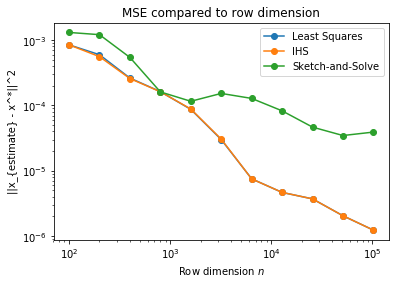

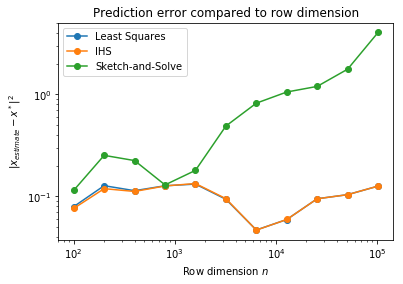

In [603]:
test_all_methods(100)